In [ ]:
#在本地运行时，无需运行此行

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = r'C:\Users\jlovey\Desktop\cs231n\CS231N-ag1-2021\assignment1\cs231n\datasets\cifar-10-python\cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


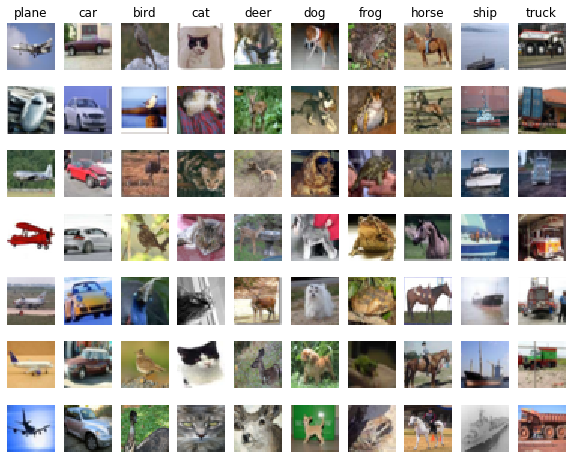

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
#print(mask)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


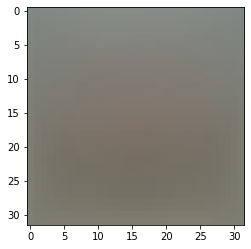

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show() #well,I can't see anything.

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.707774


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

**SVM的loss和梯度推导**

$$
L_{i} = \sum_{j\ne y_i}^{class\_ num} \max\left(0,s_j-s_{y_i}+\Delta \right) = \sum_{j\ne y_i}^{class\_ num} \max\left(0,w_j\cdot x_i^T - w_{y_i}\cdot x_t^T +\Delta \right) + \lambda R(W)
$$

$$ 
\begin{align*}
&\left(j \neq y_{i}, w_{j} \cdot x_{i}^{T}-w_{y_{i}} \cdot x_{i}^{T}+\Delta>0\right) \frac{\partial L_{i}}{\partial \mathrm{s}_{j}}=x_{i}^{T} \\ 
&\left(j=y_{i}, w_{j} \cdot x_{i}^{T}-w_{y_{i}} \cdot x_{i}^{T}+\Delta>0\right) \frac{\partial L_{i}}{\partial \mathrm{s}_{y_{i}}}=-x_{i}^{T} \\
&\left(w_{j} \cdot x_{i}^{T}-w_{y_{i}} \cdot x_{i}^{T}+\Delta \leq 0\right) \frac{\partial L_{i}}{\partial \mathrm{s}_{j}}=0
\end{align*}
$$

在本项目中，
$$
S = X@W,\frac{\rm{d}S}{\rm{d}W} = X
$$
假设 X:(2,4),W(4,3),S(2,3)进行举例分析：

Score:
| $s_{11}$ | $s_{12}$**(correct)** | $s_{13}$              |
|:--------:|:---------------------:|:---------------------:|
| $s_{21}$ | $s_{22}$              | $s_{23}$**(correct)** |
$$
\begin{align*}
L_1 &= \max(0,s_{11}-s_{12}+1) + \max(0,s_{13}-s_{12}+1)\\
L_2 &= \max(0,s_{21}-s_{23}+1) + \max(0,s_{22}-s_{23}+1)\\
L &= (L_1+L_2)/2
\end{align*}
$$

$$
\begin{align*}
&\text{as for wrong label: }\frac{\rm{d} L}{\rm{d} s_{11}} = \frac{1}{2} \times 1 \text{(if }s_{11} - s_{12} + 1 >0 \text{)}\\
&\text{as for correct label: }\frac{\rm{d} L}{\rm{d} s_{12}} = -1 \text{(if }s_{11} - s_{12} + 1 >0 \text{)} + (-1)\text{(if }s_{13} - s_{12} + 1 >0 \text{)}
\end{align*}
$$

$$
\frac{\rm{d} L}{\rm{d} W} = \frac{\rm{d}L}{\rm{d}S} \times \frac{\rm{d}S}{\rm{d}W}
$$

反向传播时，要注意grad要加上正则化的梯度参数。此处采用的是l2正则化
$$
L(W)=\frac{1}{N}\sum_{i=1}^N L_{i}\left( f\left(x_i,W\right),y_i \right) + \lambda R(W)
$$


In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.714146 analytic: 7.714146, relative error: 1.556649e-11
numerical: 6.067138 analytic: 6.067138, relative error: 7.553231e-11
numerical: 19.278126 analytic: 19.278126, relative error: 1.348393e-11
numerical: -0.035833 analytic: -0.035833, relative error: 1.228369e-08
numerical: -5.991894 analytic: -5.991894, relative error: 7.643190e-11
numerical: 22.268186 analytic: 22.268186, relative error: 1.259338e-11
numerical: 10.885295 analytic: 10.885295, relative error: 1.358464e-12
numerical: -22.775672 analytic: -22.775672, relative error: 4.348222e-12
numerical: 13.939089 analytic: 13.939089, relative error: 1.130074e-11
numerical: 6.574053 analytic: 6.574053, relative error: 6.707874e-11
numerical: 23.355340 analytic: 23.355340, relative error: 2.563302e-12
numerical: 16.218265 analytic: 16.218265, relative error: 6.575304e-12
numerical: 8.237030 analytic: 8.237030, relative error: 1.900180e-11
numerical: 0.099262 analytic: 0.099262, relative error: 4.729950e-10
numerical: 11.

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ 

计算**SVM loss**，我们使用的是**Hinge loss**，形式为 $\max(0,-)$。在一维情况下，假设：$\hat y$ - score, $i$ - any class, $c$ - correct class, $\Delta$ - margin:

$$f(x)=\max(0, x),\ \text{where}\ x=\hat y_{i}-\hat y_c+\Delta$$

参考导数的定义及 _gradient\_check.py_ ，对$f(x)$求导
$$\frac{df(x)}{dx}=\lim_{h\to 0}\frac{\max(0, x+h)-\max(0,x-h)}{2h}$$

由此对 _numeric_ and _analytic_ 梯度计算进行讨论:
1. **Cause of mismatch**
  * _精度问题_ - 在上面一栏的 _numerical_ 和 _analytic_ 的结果比较中，可以看到 _relative error_ 是存在的，但是很小，大部分基本都是 $10^{-11}$ 的数量级，基本上可以相对来说可以忽略不计。造成这个的原因，应该是因为 _analytic_ 的计算，是理论计算中梯度值， 但 _numeric_ 的结果只能是不断逼近真实值，这取决于 $h$ 逼近于 $0$ 的程度。
  * _Hinge函数零点不可导_ - $\max(0,-)$ 函数在零点处不可导，导数的不连续性导致了梯度不匹配的现象。这和 $h$ 的取值有关，下面第三点进行举例说明。这也是导致了在上面数值梯度结果和解析梯度结果对比中，有部分偏差为$10^{-3}$
2. **Concerns**
  * 比较 _analytic_ and _numeric_ 两种不同的梯度计算方法，精度问题的担忧并不达，由于精度问题所带来的偏差是可预测的。由于导数不连续性所导致的梯度不匹配，是不可预测的，这个不可预测的值可能会影响参数的更新，这是一个值得考虑的事情。
3. **1D example of numeric gradient fail**
    假设 $x=-10^{-7}$ 
    * _analytic_ 梯度计算 $\max(0, x)$ 是 $0$。
    * _numeric_ 梯度计算中，若取 $h=10^{-6}$, 则 _numeric_ 梯度计算为：$\frac{f(x+h)-f(x-h)}{2h}=\frac{9\times 10^{-7}}{2\times 10^{-6}} = 0.45$。若取 $h=10^{-9}$，则 _numeric_ 梯度计算为：$\frac{f(x+h)-f(x-h)}{2h}=0$
4. **Relation between margin and mismatch**
  * 假设其他参数不变, 增大 $\Delta$ 的取值，将会降低由于导数不连续所带来的影响。因为更大的 $\Delta$ 值将会使得 $x=\hat y_{i}-\hat y_c+\Delta$ 增大，从而减少 $x\to 0$ 时所产生的问题。
  * 不过，训练的意义就在不断调整权重矩阵W，使得 $\hat y_i - \hat y_c +\Delta (i\ne c)$ 尽量小于0。所以在训练时，$x$的取值也将是会在 $0$的附近徘徊（与 softmax 算法不同，softmax会尽量增大正确得分\概率）。所以从这个角度思考，增大$\Delta$起到的效果应该不大。


In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.707774e+00 computed in 0.124383s
Vectorized loss: 8.707774e+00 computed in 0.012179s
difference: -0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.117283s
Vectorized loss and gradient: computed in 0.002994s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 788.106446
iteration 100 / 1500: loss 287.072535
iteration 200 / 1500: loss 108.026050
iteration 300 / 1500: loss 42.840981
iteration 400 / 1500: loss 18.722823
iteration 500 / 1500: loss 10.061833
iteration 600 / 1500: loss 7.153897
iteration 700 / 1500: loss 6.200033
iteration 800 / 1500: loss 5.444013
iteration 900 / 1500: loss 5.959000
iteration 1000 / 1500: loss 5.429602
iteration 1100 / 1500: loss 5.381888
iteration 1200 / 1500: loss 5.441603
iteration 1300 / 1500: loss 5.233032
iteration 1400 / 1500: loss 5.253665
That took 17.516006s


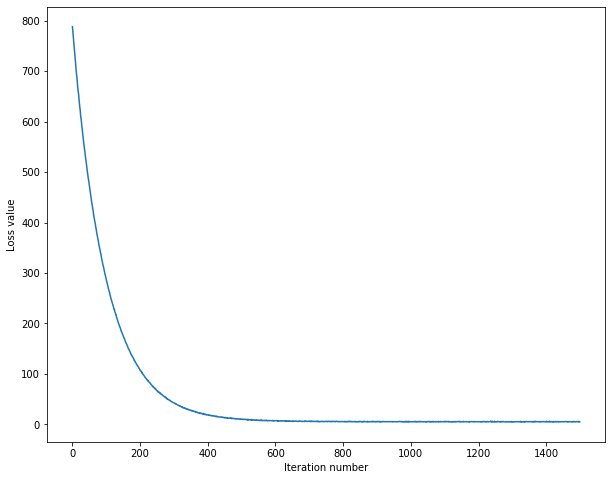

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.365388
validation accuracy: 0.384000


In [38]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.random.randint(150, 250, 5)*1e-9
regularization_strengths = np.random.randint(1, 10, 5)*1e3

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create SVM and train it 
    svm = LinearSVM()
    svm.train(X_train, y_train, lr, reg, num_iters=1000)

    # Compute training and validation sets accuracies and append to the dictionary
    y_train_pred, y_val_pred = svm.predict(X_train), svm.predict(X_val)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.640000e-07 reg 1.000000e+03 train accuracy: 0.318612 val accuracy: 0.319000
lr 1.640000e-07 reg 4.000000e+03 train accuracy: 0.369429 val accuracy: 0.369000
lr 1.640000e-07 reg 8.000000e+03 train accuracy: 0.378163 val accuracy: 0.383000
lr 1.640000e-07 reg 9.000000e+03 train accuracy: 0.385776 val accuracy: 0.397000
lr 1.850000e-07 reg 1.000000e+03 train accuracy: 0.329939 val accuracy: 0.335000
lr 1.850000e-07 reg 4.000000e+03 train accuracy: 0.370102 val accuracy: 0.378000
lr 1.850000e-07 reg 8.000000e+03 train accuracy: 0.373163 val accuracy: 0.371000
lr 1.850000e-07 reg 9.000000e+03 train accuracy: 0.381510 val accuracy: 0.388000
lr 2.120000e-07 reg 1.000000e+03 train accuracy: 0.339327 val accuracy: 0.342000
lr 2.120000e-07 reg 4.000000e+03 train accuracy: 0.379102 val accuracy: 0.369000
lr 2.120000e-07 reg 8.000000e+03 train accuracy: 0.380449 val accuracy: 0.391000
lr 2.120000e-07 reg 9.000000e+03 train accuracy: 0.378265 val accuracy: 0.386000
lr 2.230000e-07 reg 1.000000

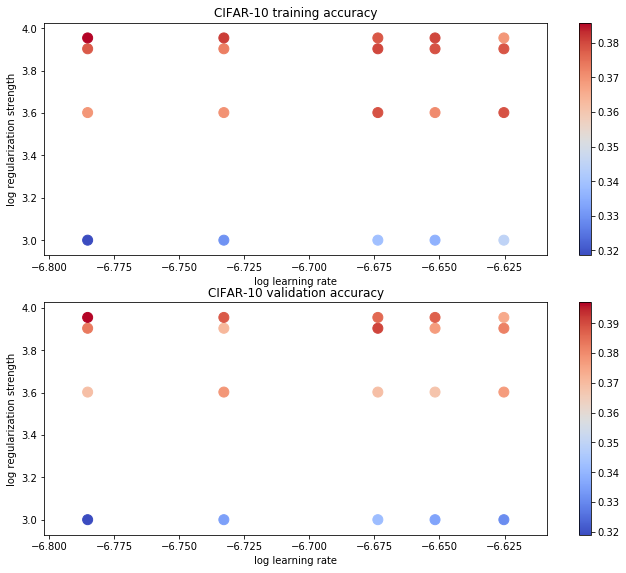

In [39]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [40]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.380000


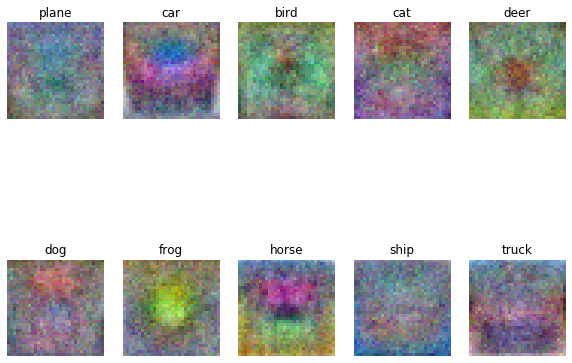

In [41]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ 

每个类的可视化的**SVM**权重看起来像是该类的不同图像的组合。它们看起来像是图像特征的粗略概括。不同类别的SVM的权重图，像是该类别图像的模糊模板。

解释：
* 从图中可以看到car那一类的权重图像，与车的正面图是比较匹配的。dog那一类，可以看到有项圈，frog那一类的中间是绿色的等。
* 因为权重跟训练集的图像越相似的话，做内积的时候得分越高，通过训练svm会使得权重跟该类别的平均值接近 


